In [1]:
'''
Usage:
1. Directory with data sets must be placed in directory named "input"
2. Input directory must be in the same directory as the .ipynb file with this sript
3. Inside each data set directory there must be three directories named: images, labels and masks.
4. Filenames of labels and masks files must be the same as image filename.
'''

'\nUsage:\n1. Directory with data sets must be placed in directory named "input"\n2. Input directory must be in the same directory as the .ipynb file with this sript\n3. Inside each data set directory there must be three directories named: images, labels and masks.\n4. Filenames of labels and masks files must be the same as image filename.\n'

In [2]:
import numpy as np
import os
import collections
import matplotlib.pyplot as plt
import skimage.future.graph as skigraph
import shutil
import pickle
import keras
import tensorflow as tf
import networkx as nx
import time
import sys
import shutil
from sklearn.metrics import confusion_matrix

from kgcnn.literature.GCN import make_model
from kgcnn.utils.data import ragged_tensor_from_nested_numpy
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from kgcnn.utils.learning import LinearLearningRateScheduler
from PIL import Image, ImageOps
import radiomics
import numpy.ma as ma
import nrrd
import warnings
from collections import defaultdict

In [3]:
# script parameterss
DATA_SET_DIR_NAME = "data_set_2"
PYRADIOMICS_FEATURES = [
    "original_firstorder_Mean",
    "original_firstorder_Variance",
    "original_glcm_ClusterTendency",
    "original_glcm_Correlation",
    "original_ngtdm_Contrast",
    "original_glrlm_RunEntropy",
    "original_gldm_DependenceEntropy",
    "original_gldm_SmallDependenceEmphasis",
    "original_glrlm_GrayLevelNonUniformity",
    "original_ngtdm_Busyness",
    "original_glszm_ZoneEntropy",
    "original_glszm_SizeZoneNonUniformity"
]
WHITE_SUPERPIXEL_LABEL_TRESHOLD = 0.65

# globals
DATA_DIR_PATH = f"./input/{DATA_SET_DIR_NAME}"
IMAGES_DIR_PATH = f"{DATA_DIR_PATH}/images"
SUPERPIXELS_LABELS_DIR_PATH = f"{DATA_DIR_PATH}/superpixels_labels"
MASKS_DIR_PATH = f"{DATA_DIR_PATH}/masks"

In [4]:
# utils
def save_object(filename, obj):
    obj_file = open(filename, "wb")
    pickle.dump(obj, obj_file)
    obj_file.close()
    
def load_object(filename):
    obj_file = open(filename, "rb")
    obj = pickle.load(obj_file)
    obj_file.close()
    
    return obj

class Graph:
    def __init__(self, file_id, rag, image, superpixels_labels, mask):
        self.file_id = file_id
        self.rag = rag
        self.image = image
        self.superpixels_labels = superpixels_labels
        self.mask = mask

class Subgraph:
    def __init__(self, rag, graph, middle_superpixel_label, label):
        self.rag = rag
        self.graph = graph
        self.middle_superpixel_label = middle_superpixel_label
        self.label = label
        self.unnormalized_edge_indices = None
        self.normalized_edge_indices = None
        self.edges = None
        self.nodes = None
        
def assign_labels(graph):
    white_pixels_count = defaultdict(int)
    total_pixels_count = defaultdict(int)
    
    for (i, row) in enumerate(graph.superpixels_labels):
        for (j, superpixel_label) in enumerate(row):
            total_pixels_count[superpixel_label] += 1
            if graph.mask[i][j] == 1:
                white_pixels_count[superpixel_label] += 1
      
    for node in graph.rag:
        graph.rag.nodes[node]['label'] = 1.0 if white_pixels_count[node] / total_pixels_count[node] >= WHITE_SUPERPIXEL_LABEL_TRESHOLD else 0.0
            
            
def assign_features(graph):
    unique_superpixels_labels = np.unique(graph.superpixels_labels)
    
    for superpixel_label in unique_superpixels_labels:
        superpixel_label_mask = (graph.superpixels_labels == superpixel_label).astype(int)
        NRRD_DIRECTORY_PATH = "./output/nrrd"
        NRRD_ITEM_DIRECTORY_PATH = f"{NRRD_DIRECTORY_PATH}/{graph.file_id}"
        os.makedirs(NRRD_ITEM_DIRECTORY_PATH, exist_ok=True)
        
        os.makedirs(f"{NRRD_ITEM_DIRECTORY_PATH}", exist_ok=True)
        nrrd.write(f"{NRRD_ITEM_DIRECTORY_PATH}/{superpixel_label}_image.nrrd", graph.image)
        nrrd.write(f"{NRRD_ITEM_DIRECTORY_PATH}/{superpixel_label}_superpixel_label_mask.nrrd", superpixel_label_mask)
        nrrd_image_path = os.path.join(f"{NRRD_ITEM_DIRECTORY_PATH}", str(superpixel_label) + "_image.nrrd")
        nrrd_superpixel_label_mask_path = os.path.join(f"{NRRD_ITEM_DIRECTORY_PATH}", str(superpixel_label) + "_superpixel_label_mask.nrrd")
        
        extractor = radiomics.featureextractor.RadiomicsFeatureExtractor(minimumROIDimensions=1)
        result = extractor.execute(nrrd_image_path, nrrd_superpixel_label_mask_path)  
                
        for feature in PYRADIOMICS_FEATURES:
            graph.rag.nodes[superpixel_label][feature] = result[feature]
    
def process_images():
    filenames = os.listdir(IMAGES_DIR_PATH)
    graphs = list()
    shutil.rmtree("./output")
    os.makedirs("./output/expected", exist_ok=True)
    
    for (file_count, filename) in enumerate(filenames, start=1):
        print(f"Processing files: {file_count}/{len(filenames)}")
        
        file_id = os.path.splitext(filename)[0]
        
        try:
            image = np.array(ImageOps.grayscale(Image.open(f"{IMAGES_DIR_PATH}/{filename}")))
            mask = np.array(ImageOps.grayscale(Image.open(f"{MASKS_DIR_PATH}/{file_id}.bmp")))
            superpixels_labels = np.fromfile(f"{SUPERPIXELS_LABELS_DIR_PATH}/{file_id}.dat", dtype=np.dtype((np.int32, image.shape)))[0]
        except FileNotFoundError as error: 
            print(error)
            
        rag = skigraph.rag_mean_color(image, superpixels_labels)
        graphs.append(Graph(file_id, rag, image, superpixels_labels, mask))
        assign_labels(graphs[-1])
        assign_features(graphs[-1])
        
        expected = Image.fromarray((mask*255).astype(np.uint8))
        expected.save(f"./output/expected/{file_id}.png")
        
    print("All files have been processed")
    
    return graphs

def split_into_subgraphs(graphs):
    subgraphs = []
    for graph in graphs:
        for node in graph.rag.nodes:
            nodes = [neighbor for neighbor in graph.rag.neighbors(node)] + [node]
            rag = graph.rag.subgraph(nodes)
            label = graph.rag.nodes[node]['label']
            subgraphs.append(Subgraph(rag, graph, node, label))
            
    return subgraphs

def normalize_edge_indices(edge_indices):
    flat_list = [node for edge_index in edge_indices for node in edge_index]            
    flat_list.sort()
    flat_list = list(dict.fromkeys(flat_list))
    change = {key:value for (value, key) in enumerate(flat_list)}
    result = [[change[edge_index[0]], change[edge_index[1]]] for edge_index in edge_indices] 
    
    return result

def prepare_data(subgraphs):
    nodes = []
    edge_indices = []
    edges = []
    labels = []
    
    for subgraph in subgraphs:
        node_features = []
        
        for node in subgraph.rag.nodes:
            node_features.append([subgraph.rag.nodes[node][feature] for feature in PYRADIOMICS_FEATURES])
            
        nodes.append(node_features)
        edges.append([[1.0] for edge in subgraph.rag.edges.data()])
        unnormalized_edge_indices = [list(index) for index in subgraph.rag.edges]
        edge_indices.append(normalize_edge_indices(unnormalized_edge_indices))
        labels.append(subgraph.label)
        
        subgraph.nodes = nodes[-1]
        subgraph.unnormalized_edge_indices = unnormalized_edge_indices
        subgraph.normalized_edge_indices = edge_indices[-1]
        subgraph.edges = edges[-1]

    return nodes, edge_indices, edges, np.array(labels)


def generate_segmented_images_from_predictions(subgraphs, predictions):
    predicted_images = {}
    os.makedirs("./output/generated", exist_ok=True)

    for (prediction_count, subgraph) in enumerate(subgraphs):
        if subgraph.graph.file_id not in predicted_images:
            predicted_images[subgraph.graph.file_id] = np.copy(subgraph.graph.superpixels_labels)
        predicted_images[subgraph.graph.file_id][predicted_images[subgraph.graph.file_id] == subgraph.middle_superpixel_label] = predictions[prediction_count] - 2

    for file_id in predicted_images.keys():
        predicted_images[file_id][predicted_images[file_id] == -1] = 255
        predicted_images[file_id][predicted_images[file_id] == -2] = 0
        generated = Image.fromarray(predicted_images[file_id].astype(np.uint8))
        generated.save(f"./output/generated/{file_id}.png")

In [5]:
import logging
logger = logging.getLogger("radiomics")
logger.setLevel(logging.ERROR)

graphs = process_images()

Processing files: 1/140
Processing files: 2/140
Processing files: 3/140
Processing files: 4/140
Processing files: 5/140
Processing files: 6/140
Processing files: 7/140
Processing files: 8/140
Processing files: 9/140
Processing files: 10/140
Processing files: 11/140
Processing files: 12/140
Processing files: 13/140
Processing files: 14/140
Processing files: 15/140
Processing files: 16/140
Processing files: 17/140
Processing files: 18/140
Processing files: 19/140
Processing files: 20/140
Processing files: 21/140
Processing files: 22/140
Processing files: 23/140
Processing files: 24/140
Processing files: 25/140
Processing files: 26/140
Processing files: 27/140
Processing files: 28/140
Processing files: 29/140
Processing files: 30/140
Processing files: 31/140
Processing files: 32/140
Processing files: 33/140
Processing files: 34/140
Processing files: 35/140
Processing files: 36/140
Processing files: 37/140
Processing files: 38/140
Processing files: 39/140
Processing files: 40/140
Processin

/home/daniel/anaconda3/lib/python3.8/site-packages/radiomics/glcm.py:654: RuntimeWarning: invalid value encountered in sqrt
  MCC = numpy.sqrt(Q_eigenValue[:, :, -2])  # 2nd highest eigenvalue


Processing files: 67/140
Processing files: 68/140
Processing files: 69/140
Processing files: 70/140
Processing files: 71/140
Processing files: 72/140
Processing files: 73/140
Processing files: 74/140
Processing files: 75/140
Processing files: 76/140
Processing files: 77/140
Processing files: 78/140
Processing files: 79/140
Processing files: 80/140
Processing files: 81/140
Processing files: 82/140
Processing files: 83/140
Processing files: 84/140
Processing files: 85/140
Processing files: 86/140
Processing files: 87/140
Processing files: 88/140
Processing files: 89/140
Processing files: 90/140
Processing files: 91/140
Processing files: 92/140
Processing files: 93/140
Processing files: 94/140
Processing files: 95/140
Processing files: 96/140
Processing files: 97/140
Processing files: 98/140
Processing files: 99/140
Processing files: 100/140
Processing files: 101/140
Processing files: 102/140
Processing files: 103/140
Processing files: 104/140


/home/daniel/anaconda3/lib/python3.8/site-packages/radiomics/glcm.py:599: RuntimeWarning: invalid value encountered in sqrt
  imc2 = (1 - numpy.e ** (-2 * (HXY2 - HXY))) ** 0.5


Processing files: 105/140
Processing files: 106/140
Processing files: 107/140
Processing files: 108/140
Processing files: 109/140
Processing files: 110/140
Processing files: 111/140
Processing files: 112/140
Processing files: 113/140
Processing files: 114/140
Processing files: 115/140
Processing files: 116/140
Processing files: 117/140
Processing files: 118/140
Processing files: 119/140
Processing files: 120/140
Processing files: 121/140
Processing files: 122/140
Processing files: 123/140
Processing files: 124/140
Processing files: 125/140
Processing files: 126/140
Processing files: 127/140
Processing files: 128/140
Processing files: 129/140
Processing files: 130/140
Processing files: 131/140
Processing files: 132/140
Processing files: 133/140
Processing files: 134/140
Processing files: 135/140
Processing files: 136/140
Processing files: 137/140
Processing files: 138/140
Processing files: 139/140
Processing files: 140/140
All files have been processed


In [6]:
graphs_train, graphs_test = train_test_split(graphs, train_size=0.8, random_state=1)

subgraphs_train = split_into_subgraphs(graphs_train)
subgraphs_test = split_into_subgraphs(graphs_test)

nodes_train, edge_indices_train, edges_train, labels_train =  prepare_data(subgraphs_train)
nodes_test, edge_indices_test, edges_test, labels_test =  prepare_data(subgraphs_test)

nodes_train = ragged_tensor_from_nested_numpy(nodes_train)
edges_train = ragged_tensor_from_nested_numpy(edges_train)
edge_indices_train = ragged_tensor_from_nested_numpy(edge_indices_train)

nodes_test = ragged_tensor_from_nested_numpy(nodes_test)
edges_test = ragged_tensor_from_nested_numpy(edges_test)
edge_indices_test = ragged_tensor_from_nested_numpy(edge_indices_test)

xtrain = nodes_train, edges_train, edge_indices_train
xtest = nodes_test, edges_test, edge_indices_test
ytrain = labels_train
ytest = labels_test
print([x.shape for x in xtrain])
print([x.shape for x in xtest])
print(ytrain.shape, ytest.shape)

[TensorShape([28151, None, 12]), TensorShape([28151, None, 1]), TensorShape([28151, None, 2])]
[TensorShape([7526, None, 12]), TensorShape([7526, None, 1]), TensorShape([7526, None, 2])]
(28151,) (7526,)


INFO:kgcnn: Updated model kwargs:
{'depth': 1,
 'gcn_args': {'activation': 'relu',
              'has_unconnected': True,
              'is_sorted': False,
              'normalize_by_weights': False,
              'pooling_method': 'mean',
              'units': 64,
              'use_bias': True},
 'input_embedding': {'edge': {'input_dim': 10, 'output_dim': 64},
                     'node': {'input_dim': 55, 'output_dim': 64}},
 'inputs': [{'dtype': 'float32',
             'name': 'node_attributes',
             'ragged': True,
             'shape': (None, 12)},
            {'dtype': 'float32',
             'name': 'edge_attributes',
             'ragged': True,
             'shape': (None, 1)},
            {'dtype': 'int64',
             'name': 'edge_indices',
             'ragged': True,
             'shape': (None, 2)}],
 'name': 'GCN',
 'output_embedding': 'graph',
 'output_mlp': {'activation': ['relu', 'relu', 'sigmoid'],
                'units': [140, 70, 1],
                '

/home/daniel/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
node_attributes (InputLayer)    [(None, None, 12)]   0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, None, 64)     832         node_attributes[0][0]            
__________________________________________________________________________________________________
edge_attributes (InputLayer)    [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
edge_indices (InputLayer)       [(None, None, 2)]    0                                            
______________________________________________________________________________________________

/home/daniel/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/gcn/pooling_weighted_local_edges/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/gcn/pooling_weighted_local_edges/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model/gcn/pooling_weighted_local_edges/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/daniel/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/gcn/gather_nodes_outgoing/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model/gcn/gather_nodes_outgoing/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/m

880/880 - 3s - loss: 0.4972 - accuracy: 0.8196
Epoch 2/150
880/880 - 2s - loss: 0.3074 - accuracy: 0.8615
Epoch 3/150
880/880 - 2s - loss: 0.2789 - accuracy: 0.8740
Epoch 4/150
880/880 - 2s - loss: 0.2642 - accuracy: 0.8798
Epoch 5/150
880/880 - 2s - loss: 0.2592 - accuracy: 0.8818
Epoch 6/150
880/880 - 2s - loss: 0.2599 - accuracy: 0.8816
Epoch 7/150
880/880 - 2s - loss: 0.2541 - accuracy: 0.8842
Epoch 8/150
880/880 - 2s - loss: 0.2502 - accuracy: 0.8860
Epoch 9/150
880/880 - 2s - loss: 0.2496 - accuracy: 0.8861
Epoch 10/150
880/880 - 2s - loss: 0.2497 - accuracy: 0.8861 - val_loss: 0.2002 - val_accuracy: 0.9115
Epoch 11/150
880/880 - 2s - loss: 0.2485 - accuracy: 0.8860
Epoch 12/150
880/880 - 2s - loss: 0.2502 - accuracy: 0.8877
Epoch 13/150
880/880 - 2s - loss: 0.2440 - accuracy: 0.8890
Epoch 14/150
880/880 - 2s - loss: 0.2436 - accuracy: 0.8878
Epoch 15/150
880/880 - 2s - loss: 0.2425 - accuracy: 0.8902
Epoch 16/150
880/880 - 2s - loss: 0.2432 - accuracy: 0.8882
Epoch 17/150
880/88

880/880 - 2s - loss: 0.2163 - accuracy: 0.8990
Epoch 130/150
880/880 - 2s - loss: 0.2151 - accuracy: 0.8989 - val_loss: 0.1833 - val_accuracy: 0.9185
Epoch 131/150
880/880 - 2s - loss: 0.2153 - accuracy: 0.8999
Epoch 132/150
880/880 - 2s - loss: 0.2139 - accuracy: 0.9020
Epoch 133/150
880/880 - 2s - loss: 0.2150 - accuracy: 0.9007
Epoch 134/150
880/880 - 2s - loss: 0.2146 - accuracy: 0.8988
Epoch 135/150
880/880 - 2s - loss: 0.2135 - accuracy: 0.9005
Epoch 136/150
880/880 - 2s - loss: 0.2134 - accuracy: 0.9008
Epoch 137/150
880/880 - 2s - loss: 0.2126 - accuracy: 0.9011
Epoch 138/150
880/880 - 2s - loss: 0.2128 - accuracy: 0.9014
Epoch 139/150
880/880 - 2s - loss: 0.2123 - accuracy: 0.9013
Epoch 140/150
880/880 - 2s - loss: 0.2108 - accuracy: 0.9004 - val_loss: 0.1835 - val_accuracy: 0.9171
Epoch 141/150
880/880 - 2s - loss: 0.2109 - accuracy: 0.9014
Epoch 142/150
880/880 - 2s - loss: 0.2103 - accuracy: 0.9011
Epoch 143/150
880/880 - 2s - loss: 0.2100 - accuracy: 0.9006
Epoch 144/150
8

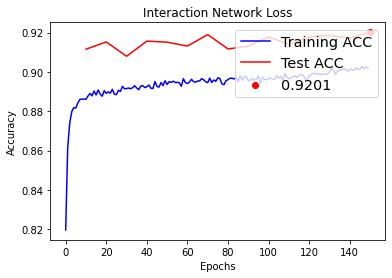

In [7]:
model = make_model(
    name = "GCN",
    inputs = [{'shape': (None, 12), 'name': "node_attributes", 'dtype': 'float32', 'ragged': True},
            {'shape': (None, 1), 'name': "edge_attributes", 'dtype': 'float32', 'ragged': True},
            {'shape': (None, 2), 'name': "edge_indices", 'dtype': 'int64', 'ragged': True}],
    input_embedding = {"node": {"input_dim": 55, "output_dim": 64},
                       "edge": {"input_dim": 10, "output_dim": 64}},
    output_embedding =  'graph',
    output_mlp = {"use_bias": [True, True, False], "units": [140, 70, 1],
                "activation": ['relu', 'relu', 'sigmoid']},
    gcn_args = {"units": 64, "use_bias": True, "activation": 'relu', "pooling_method": 'mean', 
                "normalize_by_weights": False},
    depth = 1
)

learning_rate_start = 1e-3
learning_rate_stop = 1e-4
epo = 150
epomin = 100
epostep = 10

optimizer = tf.keras.optimizers.Adam(lr=learning_rate_start)
cbks = LinearLearningRateScheduler(learning_rate_start, learning_rate_stop, epomin, epo)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              weighted_metrics=['accuracy'])
print(model.summary())

start = time.process_time()
hist = model.fit(xtrain, ytrain,
                 epochs=epo,
                 batch_size=32,
                 callbacks=[cbks],
                 validation_freq=epostep,
                 validation_data=(xtest, ytest),
                 verbose=2
                 )
stop = time.process_time()
print("Print Time for taining: ", stop - start)

trainlossall = np.array(hist.history['accuracy'])
testlossall = np.array(hist.history['val_accuracy'])
acc_valid = testlossall[-1]

plt.figure()
plt.plot(np.arange(trainlossall.shape[0]), trainlossall, label='Training ACC', c='blue')
plt.plot(np.arange(epostep, epo + epostep, epostep), testlossall, label='Test ACC', c='red')
plt.scatter([trainlossall.shape[0]], [acc_valid], label="{0:0.4f} ".format(acc_valid), c='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Interaction Network Loss')
plt.legend(loc='upper right', fontsize='x-large')
plt.show()

In [8]:
probability = model.predict(xtest)
predictions = np.round(probability)
confusion_matrix(ytest, predictions)

array([[5588,  334],
       [ 267, 1337]])

In [9]:
generate_segmented_images_from_predictions(subgraphs_test, predictions)